###Import all needed libraries

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from torch.optim import AdamW # Import AdamW from torch.optim
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [30]:
# Download NLTK resources
try:
    nltk.download('stopwords')
    nltk.download('punkt')
    nltk.download('wordnet')
    nltk.download('omw-1.4')
    nltk.download('punkt_tab') # Add download for punkt_tab
except:
    print("NLTK resources already downloaded or download failed")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [31]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [34]:
# let's create a sample dataset structure
# In practice, you would load your fake news dataset here
def create_sample_data():
    """Create sample data for demonstration"""
    np.random.seed(42)

    # Sample real news snippets
    real_news = [
        "Scientists discover new species in Amazon rainforest with potential medical benefits",
        "Economic growth shows positive trends in the third quarter according to government reports",
        "New education policy aims to improve digital literacy among students nationwide",
        "International space station completes successful mission with new solar panels",
        "Healthcare professionals develop innovative treatment for rare diseases",
        "Renewable energy investments reach record high this fiscal year",
        "Local community celebrates cultural heritage with annual festival",
        "Technology companies collaborate on cybersecurity initiatives",
        "Climate research indicates gradual improvement in air quality",
        "Sports team achieves championship victory after decade-long drought"
    ]

    # Sample fake news snippets
    fake_news = [
        "Aliens landed in New York and are controlling the government secretly",
        "Celebrity dies mysteriously but comes back to life three days later",
        "Secret cure for cancer exists but is being hidden by pharmaceutical companies",
        "Government implanting microchips through COVID vaccines to track citizens",
        "Earth is flat and NASA has been lying to us for decades",
        "Drinking bleach cures all diseases according to secret research",
        "Famous politician revealed to be shape-shifting reptile in human form",
        "Moon landing was completely faked in Hollywood studio",
        "Eating certain vegetables causes instant weight loss without exercise",
        "Secret society controls world events from underground bunker"
    ]

    # Create DataFrame
    data = {
        'text': real_news + fake_news,
        'label': [0] * len(real_news) + [1] * len(fake_news),  # 0 = real, 1 = fake
        'title': [f"Real News {i+1}" for i in range(len(real_news))] +
                [f"Fake News {i+1}" for i in range(len(fake_news))]
    }

    return pd.DataFrame(data)

In [35]:
# Load or create dataset
print("Creating sample dataset...")
df = create_sample_data()
print(f"Dataset shape: {df.shape}")
print(f"Class distribution:\n{df['label'].value_counts()}")

Creating sample dataset...
Dataset shape: (20, 3)
Class distribution:
label
0    10
1    10
Name: count, dtype: int64


In [36]:
# Text preprocessing functions
class TextPreprocessor:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.stemmer = PorterStemmer()
        self.lemmatizer = WordNetLemmatizer()

    def clean_text(self, text):
        """Clean and preprocess text"""
        if not isinstance(text, str):
            return ""

        # Convert to lowercase
        text = text.lower()

        # Remove special characters and digits
        text = re.sub(r'[^a-zA-Z\s]', '', text)

        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()

        return text

    def tokenize(self, text):
        """Tokenize text"""
        return word_tokenize(text)

    def remove_stopwords(self, tokens):
        """Remove stopwords"""
        return [word for word in tokens if word not in self.stop_words]

    def stem_tokens(self, tokens):
        """Apply stemming"""
        return [self.stemmer.stem(word) for word in tokens]

    def lemmatize_tokens(self, tokens):
        """Apply lemmatization"""
        return [self.lemmatizer.lemmatize(word) for word in tokens]

    def full_preprocess(self, text):
        """Complete text preprocessing pipeline"""
        text = self.clean_text(text)
        tokens = self.tokenize(text)
        tokens = self.remove_stopwords(tokens)
        tokens = self.lemmatize_tokens(tokens)
        return ' '.join(tokens)

Preprocessing text data...

=== Exploratory Data Analysis ===


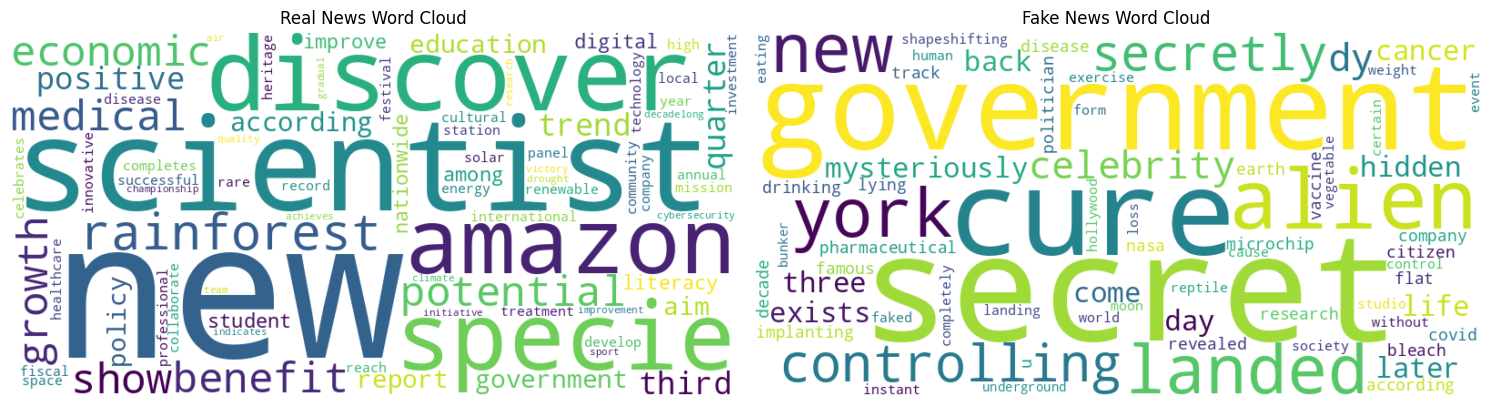

In [38]:
# Initialize preprocessor
preprocessor = TextPreprocessor()

# Apply preprocessing
print("Preprocessing text data...")
df['cleaned_text'] = df['text'].apply(preprocessor.full_preprocess)

# Exploratory Data Analysis
print("\n=== Exploratory Data Analysis ===")

# Word clouds
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
real_text = ' '.join(df[df['label'] == 0]['cleaned_text'])
wordcloud_real = WordCloud(width=800, height=400, background_color='white').generate(real_text)
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.title('Real News Word Cloud')
plt.axis('off')

plt.subplot(1, 2, 2)
fake_text = ' '.join(df[df['label'] == 1]['cleaned_text'])
wordcloud_fake = WordCloud(width=800, height=400, background_color='white').generate(fake_text)
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.title('Fake News Word Cloud')
plt.axis('off')

plt.tight_layout()
plt.savefig('wordclouds.png')
plt.show()

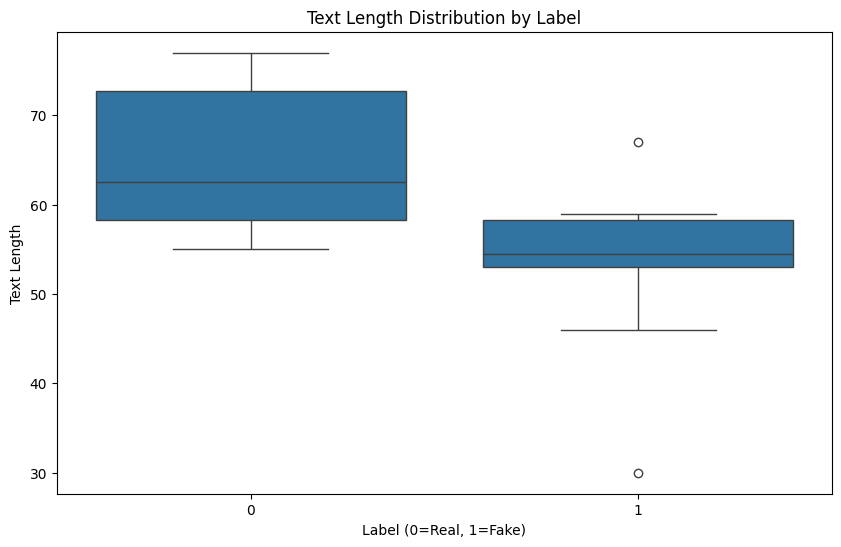

In [39]:
# Text length analysis
df['text_length'] = df['cleaned_text'].apply(len)
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='text_length', data=df)
plt.title('Text Length Distribution by Label')
plt.xlabel('Label (0=Real, 1=Fake)')
plt.ylabel('Text Length')
plt.savefig('text_length_distribution.png')
plt.show()


In [40]:
# Traditional ML Approach
print("\n=== Traditional Machine Learning Models ===")

# Prepare data for ML models
X = df['cleaned_text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define models to try
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Naive Bayes': MultinomialNB(),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'SVM': SVC(random_state=42, kernel='linear')
}

# Train and evaluate each model
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Create pipeline with TF-IDF
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
        ('clf', model)
    ])

    # Train model
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'model': pipeline
    }

    print(f"{name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(classification_report(y_test, y_pred, target_names=['Real', 'Fake']))

# Compare model performance
results_df = pd.DataFrame(results).T
print("\n=== Model Comparison ===")
print(results_df[['accuracy', 'precision', 'recall', 'f1_score']])


=== Traditional Machine Learning Models ===

Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.7500
Precision: 1.0000
Recall: 0.5000
F1-Score: 0.6667
              precision    recall  f1-score   support

        Real       0.67      1.00      0.80         2
        Fake       1.00      0.50      0.67         2

    accuracy                           0.75         4
   macro avg       0.83      0.75      0.73         4
weighted avg       0.83      0.75      0.73         4


Training Naive Bayes...
Naive Bayes Results:
Accuracy: 0.7500
Precision: 1.0000
Recall: 0.5000
F1-Score: 0.6667
              precision    recall  f1-score   support

        Real       0.67      1.00      0.80         2
        Fake       1.00      0.50      0.67         2

    accuracy                           0.75         4
   macro avg       0.83      0.75      0.73         4
weighted avg       0.83      0.75      0.73         4


Training Random Forest...
Random Forest Results:
Accuracy:

In [41]:
# Deep Learning Approach with BERT
print("\n=== Deep Learning Approach (BERT) ===")

# Custom Dataset for BERT
class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        label = self.labels.iloc[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }


=== Deep Learning Approach (BERT) ===


In [42]:
# Initialize BERT model and tokenizer
bert_model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(bert_model_name)

# Prepare data for BERT
X_train_bert, X_val_bert, y_train_bert, y_val_bert = train_test_split(
    df['text'],  # Use original text for BERT
    df['label'],
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)

# Create datasets
train_dataset = NewsDataset(X_train_bert, y_train_bert, tokenizer)
val_dataset = NewsDataset(X_val_bert, y_val_bert, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# BERT Model
class BERTNewsClassifier(nn.Module):
    def __init__(self, n_classes=2):
        super(BERTNewsClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.3)
        self.linear = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        output = self.dropout(pooled_output)
        return self.linear(output)

# Initialize model
model = BERTNewsClassifier(n_classes=2)
model.to(device)

# Training setup
optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()
num_epochs = 3

# Training function
def train_bert_model():
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader, desc="Training"):
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)

In [43]:
# Evaluation function
def evaluate_bert_model():
    model.eval()
    predictions = []
    actual_labels = []
    total_loss = 0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Evaluation"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, preds = torch.max(outputs, dim=1)

            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())

    accuracy = accuracy_score(actual_labels, predictions)
    return accuracy, total_loss / len(val_loader), predictions, actual_labels

In [44]:
# Train BERT model
print("Training BERT model...")
bert_results = {
    'train_loss': [],
    'val_loss': [],
    'val_accuracy': []
}

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")

    train_loss = train_bert_model()
    val_accuracy, val_loss, val_preds, val_labels = evaluate_bert_model()

    bert_results['train_loss'].append(train_loss)
    bert_results['val_loss'].append(val_loss)
    bert_results['val_accuracy'].append(val_accuracy)

    print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

# Add BERT results to comparison
bert_metrics = {
    'accuracy': accuracy_score(val_labels, val_preds),
    'precision': precision_score(val_labels, val_preds),
    'recall': recall_score(val_labels, val_preds),
    'f1_score': f1_score(val_labels, val_preds)
}

results_df.loc['BERT'] = bert_metrics
print("\n=== Final Model Comparison =====")
print(results_df[['accuracy', 'precision', 'recall', 'f1_score']])

# Feature Importance Analysis (for interpretable models)
print("\n=== Feature Importance Analysis ===")

# Get feature importance from Logistic Regression
lr_model = results['Logistic Regression']['model']
feature_names = lr_model.named_steps['tfidf'].get_feature_names_out()
coefficients = lr_model.named_steps['clf'].coef_[0]

# Get top features for each class
top_real_features = sorted(zip(feature_names, coefficients), key=lambda x: x[1])[:10]
top_fake_features = sorted(zip(feature_names, coefficients), key=lambda x: x[1], reverse=True)[:10]

print("Top features for REAL news:")
for feature, coef in top_real_features:
    print(f"{feature}: {coef:.4f}")

print("\nTop features for FAKE news:")
for feature, coef in top_fake_features:
    print(f"{feature}: {coef:.4f}")

# Prediction function
def predict_news(text, model_type='bert'):
    """Predict whether news is real or fake"""

    if model_type == 'bert':
        # BERT prediction
        model.eval()
        encoding = tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=128,
            return_tensors='pt'
        )

        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, prediction = torch.max(outputs, dim=1)

        return "Fake" if prediction.item() == 1 else "Real"

    else:
        # ML model prediction
        cleaned_text = preprocessor.full_preprocess(text)
        best_model = results[list(results.keys())[0]]['model']  # Use first model
        prediction = best_model.predict([cleaned_text])
        return "Fake" if prediction[0] == 1 else "Real"

# Test predictions
test_samples = [
    "Scientists confirm climate change is real and caused by human activity",
    "Secret government experiment creates zombie outbreak in hidden facility",
    "New study shows benefits of regular exercise for mental health",
    "Celebrity revealed to be immortal vampire living among humans"
]

print("\n=== Sample Predictions ===")
for i, text in enumerate(test_samples):
    prediction = predict_news(text, 'bert')
    print(f"Sample {i+1}: {prediction}")
    print(f"Text: {text}")
    print("-" * 80)

# Save the best model
print("\nSaving the best model...")
best_model_name = results_df['f1_score'].idxmax()
print(f"Best model: {best_model_name}")

if best_model_name != 'BERT':
    import joblib
    joblib.dump(results[best_model_name]['model'], 'fake_news_detector.pkl')
    print("Model saved as 'fake_news_detector.pkl'")
else:
    torch.save(model.state_dict(), 'bert_fake_news_detector.pth')
    print("BERT model saved as 'bert_fake_news_detector.pth'")

print("\n=== Fake News Detection Model Complete ===")
print("Key features implemented:")
print("1. Text preprocessing and cleaning")
print("2. Multiple ML models (Logistic Regression, Naive Bayes, Random Forest, SVM)")
print("3. Deep Learning with BERT")
print("4. Comprehensive evaluation metrics")
print("5. Feature importance analysis")
print("6. Prediction function")
print("7. Model saving and deployment ready")

Training BERT model...

Epoch 1/3


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 39.66it/s]


Train Loss: 0.7551, Val Loss: 0.6962, Val Accuracy: 0.5000

Epoch 2/3


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 40.56it/s]


Train Loss: 0.7089, Val Loss: 0.6820, Val Accuracy: 0.5000

Epoch 3/3


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 39.15it/s]

Train Loss: 0.7074, Val Loss: 0.6927, Val Accuracy: 0.5000

=== Final Model Comparison =====
                    accuracy precision recall  f1_score
Logistic Regression     0.75       1.0    0.5  0.666667
Naive Bayes             0.75       1.0    0.5  0.666667
Random Forest            0.5       0.5    1.0  0.666667
SVM                     0.75       1.0    0.5  0.666667
BERT                     0.5       0.5    1.0  0.666667

=== Feature Importance Analysis ===
Top features for REAL news:
collaborate: -0.1333
collaborate cybersecurity: -0.1333
company: -0.1333
company collaborate: -0.1333
cybersecurity: -0.1333
cybersecurity initiative: -0.1333
initiative: -0.1333
technology: -0.1333
technology company: -0.1333
air: -0.1134

Top features for FAKE news:
secret: 0.1997
decade: 0.1338
earth: 0.1338
earth flat: 0.1338
flat: 0.1338
flat nasa: 0.1338
lying: 0.1338
lying decade: 0.1338
nasa: 0.1338
nasa lying: 0.1338

=== Sample Predictions ===
Sample 1: Fake
Text: Scientists confirm climate 

In [11]:
# Example of using the predict_news function with new data
new_news_samples = [
    "Scientists have discovered a new planet orbiting a star outside our solar system.",
    "Exclusive: Secret meeting between world leaders reveals plan for global takeover.",
    "Researchers find a strong link between air pollution and respiratory illnesses.",
    "Shocking video shows a famous actor admitting to being a time traveler."
]

print("=== Predictions on New Data ===")
for i, text in enumerate(new_news_samples):
    prediction = predict_news(text, model_type='bert')
    print(f"New Sample {i+1}: {prediction}")
    print(f"Text: {text}")
    print("-" * 80)

=== Predictions on New Data ===
New Sample 1: Fake
Text: Scientists have discovered a new planet orbiting a star outside our solar system.
--------------------------------------------------------------------------------
New Sample 2: Fake
Text: Exclusive: Secret meeting between world leaders reveals plan for global takeover.
--------------------------------------------------------------------------------
New Sample 3: Real
Text: Researchers find a strong link between air pollution and respiratory illnesses.
--------------------------------------------------------------------------------
New Sample 4: Fake
Text: Shocking video shows a famous actor admitting to being a time traveler.
--------------------------------------------------------------------------------
